In [1]:
"""
Main script for FCNT tracker. 
"""
#%%
# Import custom class and functions
from inputproducer import InputProducer
from tracker import TrackerVanilla
from vgg16 import Vgg16
from selcnn import SelCNN
from sgnet import GNet, SNet
from utils import img_with_bbox, IOU_eval

import numpy as np 
import tensorflow as tf

import os

#%%
tf.app.flags.DEFINE_integer('iter_step_sel', 200,
                          """Number of steps for trainning"""
                          """selCNN networks.""")
tf.app.flags.DEFINE_integer('iter_step_sg', 50,
                          """Number of steps for trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('num_sel', 384,
                          """Number of feature maps selected.""")
tf.app.flags.DEFINE_integer('iter_max', 200,
							"""Max iter times through imgs""")

FLAGS = tf.app.flags.FLAGS

## Define varies path
DATA_ROOT = 'data/Dog1'
IMG_PATH = os.path.join(DATA_ROOT, 'img')
GT_PATH = os.path.join(DATA_ROOT, 'groundtruth_rect.txt')
VGG_WEIGHTS_PATH = 'vgg16_weights.npz'
#%%
def train_selCNN(sess, selCNN, feed_dict):
	# Initialize variables
	global_step = tf.Variable(0, trainable=False)
	selCNN_vars = selCNN.variables 
	init_vars_op = tf.initialize_variables(selCNN_vars + [global_step], name='init_selCNN')
	sess.run(init_vars_op)

	# Retrive trainning op
	train_op, losses, lr, optimizer = selCNN.train_op(global_step)
	print(sess.run(tf.report_uninitialized_variables()))
	# Train for iter_step_sel times
	# Inspects loss curve and pre_M visually
	for step in range(FLAGS.iter_step_sel):
		_, total_loss, lr_ = sess.run([train_op, losses, lr], feed_dict=feed_dict)
		print(total_loss)


def train_sgNet(sess, gnet, snet, sgt_M, ggt_M, feed_dict):
	"""
	Train sgnet by minimize the loss
	Loss = Lg + Ls
	where Li = |pre_Mi - gt_M|**2 + Weights_decay_term_i

	"""
	# Initialize sgNet variables
	sgNet_vars = gnet.variables + snet.variables
	init_SGNet_vars_op = tf.initialize_variables(sgNet_vars, name='init_sgNet')
	sess.run(init_SGNet_vars_op)

	# Define composite loss
	total_losses = snet.loss(sgt_M) + gnet.loss(ggt_M)

	# Define trainning op
	optimizer = tf.train.GradientDescentOptimizer(1e-6)
	train_op = optimizer.minimize(total_losses, var_list= sgNet_vars)

	for step in range(FLAGS.iter_step_sg):
		loss, _ = sess.run([total_losses, train_op], feed_dict = feed_dict)
		print(loss)



def gen_mask_phi(img_sz, loc):
	x,y,w,h = loc
	phi = np.zeros(img_sz)
	phi[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)] = 1
	return phi
#%%

## Instantiate inputProducer and retrive the first img
# with associated ground truth. 
inputProducer = InputProducer(IMG_PATH, GT_PATH)
img, gt, t  = next(inputProducer.gen_img)
roi_t0, _, _ = inputProducer.extract_roi(img, gt)

# Predicts the first img.
sess = tf.Session()
sess.run(tf.initialize_all_variables())
vgg = Vgg16(VGG_WEIGHTS_PATH, sess)
vgg.print_prob(roi_t0, sess)

## At t=0. Perform the following:
# 1. Train selCNN network for both local and gloabl feature maps
# 2. Train G and S networks.
assert t == 0

## Train selCNN networks with first frame roi
# reshape gt_M for compatabilities
# Gen anotated mask for target arear

lselCNN = SelCNN('sel_local', vgg.conv4_3, (1,28,28,1))
sgt_M = inputProducer.gen_mask(lselCNN.pre_M_size)
sgt_M = sgt_M[np.newaxis,:,:,np.newaxis]
feed_dict = {vgg.imgs: [roi_t0], lselCNN.gt_M: sgt_M}
train_selCNN(sess, lselCNN, feed_dict)


gselCNN = SelCNN('sel_global', vgg.conv5_3, (1,14,14,1))
ggt_M = inputProducer.gen_mask(gselCNN.pre_M_size)
ggt_M = ggt_M[np.newaxis,:,:,np.newaxis]
feed_dict[gselCNN.gt_M] = ggt_M # corrpus the other nets?
train_selCNN(sess, gselCNN, feed_dict)



"""
# Gen anotated mask for target arear
sgt_M = inputProducer.gen_mask(lselCNN.pre_M_size)
ggt_M = inputProducer.gen_mask(gselCNN.pre_M_size)

## Train selCNN networks with first frame roi
# reshape gt_M for compatabilities
sgt_M = sgt_M[np.newaxis,:,:,np.newaxis]
ggt_M = ggt_M[np.newaxis,:,:,np.newaxis]

feed_dict = {vgg.imgs: [roi_t0], 
			lselCNN.gt_M: sgt_M,
			gselCNN.gt_M: ggt_M} # corrpus the other nets?

train_selCNN(sess, lselCNN, feed_dict)
train_selCNN(sess, gselCNN, feed_dict)
"""


## At t>0. Perform target localization and distracter detection at every frame,
## perform SNget adaptive update every 20 frames, perform SNet discrimtive 
## update if distracter detection return True.


/home/xlws/repos/FCNT_bak/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


Old English sheepdog, bobtail 0.654105
miniature poodle 0.0409054
Tibetan terrier, chrysanthemum dog 0.0321338
standard poodle 0.0294567
Sealyham terrier, Sealyham 0.0269377
0.0013186425201 max of mask
(224, 224, 3)
250 max convas
[]
47.2104
45.2593
46.7317
47.18
44.6644
43.0643
51.5117
48.1411
48.0817
52.6306
49.6254
51.6094
48.0161
49.68
53.7995
49.8145
45.8518
49.4372
46.7399
53.5927
43.2706
48.4198
47.0074
46.3897
49.9589
49.1306
45.2476
53.036
52.1486
50.0065
48.6811
48.4042
49.2552
51.0576
54.9868
52.2793
52.3155
48.5909
50.1263
48.9457
50.9195
43.6886
41.4481
43.3109
45.9635
53.0822
44.9156
57.7455
50.9173
44.0012
44.7685
44.291
45.7409
51.5354
51.7353
43.9211
44.8692
44.488
46.517
46.9958
47.5994
50.0296
47.1384
45.0407
49.2531
48.0323
49.9042
48.0828
40.9667
42.5938
47.9778
47.1424
46.4303
47.874
45.5854
45.934
48.1561
43.3512
50.848
49.7946
47.8287
43.4689
47.4363
48.3542
48.0039
46.3899
50.1501
49.133
40.4459
46.4391
49.025
46.2083
45.6528
51.417
45.6306
47.712
54.9401
43.13

'\n# Gen anotated mask for target arear\nsgt_M = inputProducer.gen_mask(lselCNN.pre_M_size)\nggt_M = inputProducer.gen_mask(gselCNN.pre_M_size)\n\n## Train selCNN networks with first frame roi\n# reshape gt_M for compatabilities\nsgt_M = sgt_M[np.newaxis,:,:,np.newaxis]\nggt_M = ggt_M[np.newaxis,:,:,np.newaxis]\n\nfeed_dict = {vgg.imgs: [roi_t0], \n\t\t\tlselCNN.gt_M: sgt_M,\n\t\t\tgselCNN.gt_M: ggt_M} # corrpus the other nets?\n\ntrain_selCNN(sess, lselCNN, feed_dict)\ntrain_selCNN(sess, gselCNN, feed_dict)\n'

In [2]:

# Perform saliency maps selection 
s_sel_maps, s_idx = lselCNN.sel_feature_maps(sess, vgg.conv4_3, feed_dict,FLAGS.num_sel)
g_sel_maps, g_idx = gselCNN.sel_feature_maps(sess, vgg.conv5_3, feed_dict,FLAGS.num_sel)

assert isinstance(s_sel_maps, np.ndarray)
assert isinstance(g_sel_maps, np.ndarray)
assert len(s_sel_maps.shape) == 4

# Instantiate G and S networks.
gnet = GNet('GNet', g_sel_maps.shape)
snet = SNet('SNet', s_sel_maps.shape)

## Train G and S nets by minimizing a composite loss.
## with feeding selected saliency maps for each networks.
feed_dict = {gnet.input_maps: g_sel_maps, snet.input_maps: s_sel_maps}
train_sgNet(sess, gnet, snet, sgt_M, ggt_M, feed_dict)
s_sel_maps_t0 = s_sel_maps


Selected maps shape: (1, 28, 28, 384)
Selected maps shape: (1, 14, 14, 384)
[1, 14, 14, 36] conv1 shape
[1, 14, 14, 1] conv shape
Shape of the out put heat map for GNet is [1, 14, 14, 1]
[1, 28, 28, 36] conv1 shape
[1, 28, 28, 1] conv shape
Shape of the out put heat map for SNet is [1, 28, 28, 1]
3.81369e+06
587.055
397.535
288.233
218.495
171.34
138.315
114.729
96.9512
82.7066
71.0463
61.4729
53.5941
47.0751
41.6196
37.0214
33.1311
29.8286
27.0176
24.6142
22.5392
20.737
19.1675
17.7967
16.5959
15.5404
14.611
13.7911
13.0625
12.4123
11.826
11.2915
10.8008
10.3467
9.92522
9.53296
9.16714
8.82449
8.50235
8.19811
7.91019
7.63758
7.3794
7.13485
6.90313
6.68348
6.4752
6.27765
6.09021
5.91232


In [4]:


from queue import Queue
from scipy.misc import imresize
from operator import add




class Tracker:
	"""
	Generic tracking model. A location is represented by an affine transformation (e.g., Xt−1), which warps the
	coordinate system so that the target lies within the unit square. Particles representing possible target locations Xt, 
	at time t are sampled according to P(Xt|Xt−1), which in this case is a diagonal-covariance Gaussian centered at Xt−1.
	
	Where:
	Xt = (xt, yt, θt, st, αt, φt)
	denote x, y translation, rotation angle, scale, aspect ratio, and skew direction at time t.

	P(Xt|Xt−1) = N (Xt; Xt−1, Ψ)
	where Ψ is a diagonal covariance matrix whose elements are the corresponding variances of affine parameters, assumes the variance of each affine parameter does not change over time

	See 3.3.1 Dynamic model in http://www.cs.toronto.edu/~dross/ivt/RossLimLinYang_ijcv.pdf for reference

	Particle filter calss"""
	def __init__(self, init_location,):
		self.conf_q = Queue(maxsize=2)
		self.pre_M_q = Queue(maxsize=2)
		self.last_two_loc_q = Queue(maxsize=2)

		self.location = init_location
		self.params = self._init_params(init_location)



	def _init_params(self, init_location):
		"""Initialize tracker's parameters"""

		params = {'p_sz': 64, 'p_num': 700, 'min_conf': 0.2, 
				'mv_thr': 0.1, 'up_thr': 0.35, 'roi_scale': 2}
		diag_s = np.ceil((init_location[2]**2 + init_location[3]**2)**0.5/7)
		params['aff_sig'] = [diag_s, diag_s, 0.004, 0.0, 0.0, 0]
		params['ratio'] = init_location[2] / params['p_sz']
		
		return params

	def _qs_full(self):
		if self.conf_q.full() and self.pre_M_q.full():
			return True
		else:
			return False

	def gen_best_M(self):
		"""Returns the best pre_M in records."""
		assert self._qs_full()

		pre_Ms = [self.pre_M_q.get() for _ in range(2)]
		confs = [self.conf_q.get() for _ in range(2)]
		idx = np.argmax(confs)
		return pre_Ms[idx]


	def draw_particles(self):
		"""
		Generates particles according to 
		P(Xt|Xt−1) = N (Xt; Xt−1, Ψ)

		Args:
			aff_params: affine parameters, see class doc string for 
				specific element definition.
				[cx, cy, w/p_sz, 0, h/w, 0] for 6 degrees of freendom
				[tlx, tly, w, h] for 4 degrees of freedom.
				.
		Returns:
			aff_params_M : self.p_num*dof size matrix,
				where rows are updated randomly drawed affine 
				params, columns repersent each particles. 
		"""
		pass



	def predict_location(self, pre_M, gt_last, resize_factor, t):
		"""
		Predict location for each particle. It is calculated by
		1. compute the confidence of the i-th candidate, which is 
			the summation of all the heatmap values within the candidate region.
		2. the candidate with the highest confidence value is predicted as target.

		Args:
			img_siz: tuple(image height, image width)
			pre_M: predicted heat map
			t: index of current frame
		"""
		pass


	def get_most_conf_M(self):
		"""Returns the most confidence heat maps."""

		# Pull self.conf_records all out, and retrive 
		# the most confident heat map. 

		return updated_gt_M


	def linear_prediction(self):
		"""
		Predicts current location linnearly according
		to las two frames location. This may boost the 
		robustnesss of obejct blocking.
		"""
		pass

	def distracted(self):
		"""Distracter detection."""

		# up-sampling pre_M

		# Compute confidence according to 
		# S = with_in / with_out
		conf_within = self.compute_conf(self.pre_M_resized, self.best_p_i_loc)
		conf_all = np.sum(self.pre_M_resized)
		distracter_score = conf_within / conf_all
		print('The probability of been distracted is %s'%distracter_score)
		if distracter_score > self.params['min_conf']:
			return True
		else:
			return False
			
	@classmethod
	def compute_conf(self, roi, loc_p):
		"""Helper func for computing confidence"""
		x,y,w,h = loc_p
		conf = np.sum(roi[y-int(0.5*h): y+int(0.5*h), \
					x-int(0.5*w):x+int(0.5*w)])
		return conf

	@classmethod
	def aff2loc(self, las_loc, aff_param):
		"""Convert affine params to location."""
		assert len(aff_param)==4, 'This method only works for dof 4 aff space.'
		cur_loc = [i+j for i,j in zip(las_loc, aff_param)]
		return cur_loc


class TrackerVanilla(Tracker):
	"""Vanilla tracker

		The covariance matrix has only 4 degrees of freedom,
		specified by vertical, horizontal translation of the central
		point, variance of the width, variance of the w/h ratio.

		The corrresponding actual senarios are object replacment,
		object zoom in/out, object rotaion. Should be sufficient 
		for most cases of car tracking.

	"""
	def __init__(self, init_location):
		super(TrackerVanilla, self).__init__(init_location)
		self._update_params()

	def _update_params(self):
		"""Update aff_sig param."""
		self.params['aff_sig'] = [10, 10, 0.04, 0.04]


	def draw_particles(self, last_location):
		"""
		The covariance matrix has only 4 degrees of freedom,
		specified by vertical, horizontal translation of the central
		point, variance of the width, variance of the w/h ratio.

		The corrresponding actual senarios are object replacment,
		object zoom in/out, object rotaion. Should be sufficient 
		for most cases of car tracking.

		Args: 
			last_location: [tlx, tly, w, h]
		"""
		# Define degrees of freedom 
		dof = len(self.params['aff_sig'])

		# Construct an p_num*6 size matrix with with each 
		# column repersents one particle

		#aff_params_M = np.kron(np.ones((self.params['p_num'],1)), np.array(aff_params))

		# First onstruct a p_num*dof size normal distribution with 
		# mean 0 and sigma 1
		rand_norml_M = np.array([np.random.standard_normal(dof) for _ in range(self.params['p_num'])])

		# Then construct a affine sigma matrix
		aff_sig_M = np.kron(np.ones((self.params['p_num'], 1)), self.params['aff_sig'])

		# Update particles 
		self.aff_params_M = rand_norml_M * aff_sig_M


	def predict_location(self, pre_M, gt_last, resize_factor, t, roi_size):
		"""
		Predict location for each particle. It is calculated by
		1. compute the confidence of the i-th candidate, which is 
			the summation of all the heatmap values within the candidate region.
		2. the candidate with the highest confidence value is predicted as target.

		Args:
			img_siz: tuple(image height, image width)
			pre_M: predicted heat map
			t: index of current frame
		"""
		# transform self.aff_params_M to location_M with each column 
		# repersent [cx, cy, w, h] in the pre_M heat map
		loc_M = np.zeros(self.aff_params_M.shape)
		tlx, tly, w, h = gt
		cx, cy = roi_size // 2, roi_size // 2
		loc_M[:, 0] = cx
		loc_M[:, 1] = cy
		loc_M[:, 2] = resize_factor * w 
		loc_M[:, 3] = resize_factor * h
		loc_M += self.aff_params_M
		loc_M = loc_M.astype(np.int)

		# Upsampling pre_M bicubicly to roi_size
		pre_M_resized = imresize(pre_M[0,:,:,0], [roi_size, roi_size], interp='bicubic')

		# Compute conf for each particle 
		conf_lsit = []
		for p_i_loc in loc_M:
			conf_i = self.compute_conf(pre_M_resized, p_i_loc)
			conf_lsit += [conf_i]

		# Get index and conf score of of the most confident one
		idx = np.argmax(conf_lsit)
		self.cur_best_conf = conf_lsit[idx]
		self.conf_q.put(conf_lsit[idx])

		# Store values for computing distraction 
		self.best_p_i_loc = loc_M[idx]
		self.pre_M_resized = pre_M_resized

		# Get the corresponding aff_param which is then
		# used to predicted the cureent best location
		best_aff =  self.aff_params_M[idx]
		print('The affine paramters: [dx,dy,dw,dh] is {0}'.format(best_aff))
		self.pre_location = self.aff2loc(gt_last, best_aff)

		# Stack into records queue


		return self.pre_location




In [ ]:
tracker = TrackerVanilla(gt)

# Iter imgs
gt_last = gt 

In [11]:



# Gnerates next frame infos
img, gt_cur, t  = next(inputProducer.gen_img)
print(t)

## Crop a rectangle ROI region centered at last target location.
roi, _, resize_factor = inputProducer.extract_roi(img, gt_last)

## Perform Target localiation predicted by GNet
# Get heat map predicted by GNet
feed_dict_vgg = {vgg.imgs : [roi]}
s_maps, g_maps = sess.run([vgg.conv4_3, vgg.conv5_3], feed_dict=feed_dict_vgg)
s_sel_maps = s_maps[...,s_idx] # np.ndarray, shape = [1,28,28,num_sel]?
g_sel_maps = g_maps[...,g_idx]

feed_dict_g = { gnet.input_maps: g_sel_maps}
pre_M = sess.run(gnet.pre_M, feed_dict=feed_dict_g)
tracker.pre_M_q.put(pre_M)


2


/home/xlws/repos/FCNT_bak/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


In [12]:
# Localize target with monte carlo sampling.
tracker.draw_particles(gt_last)
pre_loc = tracker.predict_location(pre_M, gt_last, resize_factor, t, 224)
print('At time {0}, the most confident value is {1}'.format(t, tracker.cur_best_conf))

The affine paramters: [dx,dy,dw,dh] is [ -3.01449854e+01   1.97820074e+00  -3.09942053e-02   1.26708898e-02]
At time 2, the most confident value is 8495


In [13]:
pre_loc

[77.332849184344852, 133.4397456451525, 50.95978830000665, 36.028893395073922]

In [14]:
# Set predicted location to be the next frame's ground truth
gt_last = pre_loc

# Draw bbox on image. And print associated IoU score.
#img_with_bbox(img, pre_loc, gt_cur)

### adpative debug

In [16]:
assert t == 2

In [17]:
best_M.shape

(1, 14, 14, 1)

In [20]:
best_M_resized = imresize(best_M[0,:,:,0], [28, 28], interp='bicubic')

In [22]:
loss = snet.loss(best_M_resized)

In [23]:
train_op = SNet.optimizer.minimize(loss, var_list=snet.variables)

In [24]:
feed_dict_s = {snet.input_maps: s_sel_maps}

In [27]:
print('SNet adaptive finetune')
for step in range(20):
    loss_, _ = sess.run([train_op, loss], feed_dict = feed_dict_s)
    print('loss: ',loss_)

SNet adaptive finetune
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None
loss:  None


### detractor debug

In [28]:
tracker.distracted()

The probability of been distracted is 0.0292498338665


False

### descrimtive finetune 

In [29]:
phi = gen_mask_phi(roi.shape, pre_loc)

/home/xlws/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [33]:
conv4_3_t0, sgt_M, conv4_3_t, pre_M, phi = s_sel_maps_t0, sgt_M, s_sel_maps, pre_M_g, phi

In [55]:
pre_M_g = sess.run(gnet.pre_M, feed_dict=feed_dict_g)

In [34]:
sgt_M = tf.constant(sgt_M, dtype=tf.float32)
pre_M = tf.constant(pre_M, dtype=tf.float32)

Loss_t0 = tf.reduce_mean(tf.squared_difference(sgt_M, snet.pre_M))


NameError: name 'self' is not defined

In [35]:
feed_dict_t0 = {snet.input_maps: conv4_3_t0}
train_op_t0 = SNet.optimizer.minimize(Loss_t0, var_list=snet.variables)

In [56]:
pre_M_g = imresize(pre_M_g[0,:,:,0], [28, 28], interp='bicubic')
pre_M_g = tf.constant(pre_M_g[np.newaxis,:,:,np.newaxis], dtype=tf.float32)

In [57]:
pre_M_g

<tf.Tensor 'Const_2059:0' shape=(1, 28, 28, 1) dtype=float32>

In [58]:
Loss_t =  tf.reduce_sum((1-phi) * tf.reduce_mean(tf.squared_difference(pre_M_g, snet.pre_M)))
feed_dict_t = {snet.input_maps: conv4_3_t}
train_op_t = SNet.optimizer.minimize(Loss_t0, var_list=snet.variables)

In [60]:
snet.input_maps

<tf.Tensor 'SNet/selected_maps:0' shape=(1, 28, 28, 384) dtype=float32>

In [63]:
conv4_3_t = s_sel_maps

In [64]:
conv4_3_t.shape

(1, 28, 28, 384)

In [65]:
feed_dict_t = {snet.input_maps: conv4_3_t}

In [66]:
for step in range(20):
    _, loss_0 = sess.run([train_op_t0, Loss_t0], feed_dict_t0)
    _, loss_t = sess.run([train_op_t, Loss_t], feed_dict_t)
    print('Loss 0:', loss_0, 'Loss t:', loss_t)

Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07
Loss 0: 0.0283147 Loss t: 9.67777e+07


In [67]:

pre_M_s = sess.run(snet.pre_M, feed_dict=feed_dict)

# Use location predicted by SNet.
pre_loc = tracker.predict_location(pre_M_s, gt_last, resize_factor, t, 224)

TypeError: predict_location() missing 4 required positional arguments: 'gt_last', 'resize_factor', 't', and 'roi_size'

In [68]:
pre_loc = tracker.predict_location(pre_M_s, gt_last, resize_factor, t, 224)

The affine paramters: [dx,dy,dw,dh] is [  6.69195078e+00  -2.17733071e+01  -1.75411874e-02  -1.44165982e-03]


In [69]:
pre_loc

[84.024799968533131,
 111.66643851538579,
 50.942247112578784,
 36.027451735250722]

In [83]:
def img_with_bbox(img_origin, gt_1):
	img =np.copy(img_origin)
	gt_1 = [int(i) for i in gt_1]
	w, h = gt_1[2:]
	tl_x, tl_y = gt_1[:2]
	tr_x, tr_y = tl_x + w, tl_y 
	dl_x, dl_y = tl_x, tl_y + h
	dr_x, dr_y = tl_x + w, tl_y +h

	rr1, cc1 = draw.line( tl_y,tl_x, tr_y, tr_x)
	rr2, cc2 = draw.line( tl_y,tl_x, dl_y, dl_x)
	rr3, cc3 = draw.line( dr_y,dr_x, tr_y, tr_x)
	rr4, cc4 = draw.line( dr_y,dr_x, dl_y, dl_x)
	img[rr1, cc1, :] = 1
	img[rr2, cc2, :] = 1
	img[rr3, cc3, :] = 1
	img[rr4, cc4, :] = 1
	return img

In [82]:
from skimage.io import imshow
from skimage import draw
%matplotlib inline

In [88]:
import matplotlib.pylab as plt

In [90]:
plt.imsave('test.png', ib)

In [96]:
t

2

In [97]:
inputProducer.imgs_path_list[t-1].split('/')[-1]

'0002.jpg'

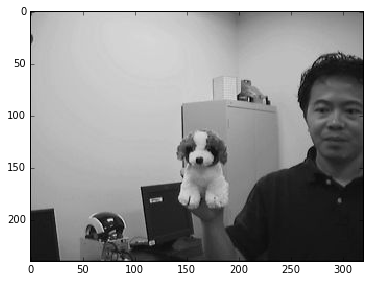

In [76]:
imshow(img)

In [77]:
gt

[139, 112, 51, 36]

In [84]:
ib = img_with_bbox(img, gt)

In [86]:
ib2 = img_with_bbox(img, pre_loc)

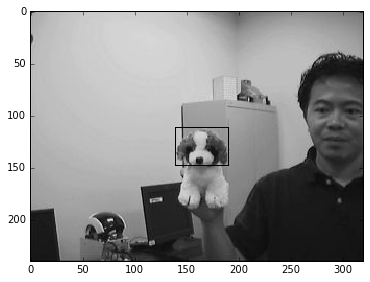

In [87]:
imshow(ib)